# Creating dummy data for Bayesian modeling
Here I create the dummy data

In [1]:
# imports
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

import openpyxl

## Create dates

In [2]:
# Create a date range
date_range = pd.date_range(start='2020-01-01', end='2025-02-28', freq='D')
print(date_range)

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2025-02-19', '2025-02-20', '2025-02-21', '2025-02-22',
               '2025-02-23', '2025-02-24', '2025-02-25', '2025-02-26',
               '2025-02-27', '2025-02-28'],
              dtype='datetime64[ns]', length=1886, freq='D')


## Get weather data

scrape google for weather data

In [3]:
# Define the URL
url = 'https://www.worldweatheronline.com/esch-sur-alzette-weather-averages/luxembourg/lu.aspx'

# Send a request to the website
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table with class "table table-striped"
table = soup.find('table', class_='table table-striped')

# Print the table to verify
print(table)

<table class="table table-striped"><thead class="thead-dark"><tr><th scope="col">Month</th><th class="text-center" scope="col">Day</th><th class="text-center" scope="col">Night</th><th class="text-center" scope="col">Rain Days</th></tr></thead><tbody>
<tr><td>January</td><td class="text-center" style="background-color:#9BF6F3;">4°c</td><td class="text-center" style="background-color:#9BF6F3;">0°c</td>
<td class="text-center">10</td></tr><tr><td>February</td><td class="text-center" style="background-color:#A4F6E9;">6°c</td><td class="text-center" style="background-color:#9BF6F3;">0°c</td>
<td class="text-center">7</td></tr><tr><td>March</td><td class="text-center" style="background-color:#80F9CC;">10°c</td><td class="text-center" style="background-color:#9BF6F3;">2°c</td>
<td class="text-center">7</td></tr><tr><td>April</td><td class="text-center" style="background-color:#73F6AB;">14°c</td><td class="text-center" style="background-color:#9BF6F3;">4°c</td>
<td class="text-center">8</td><

In [4]:
columns = [header.text for header in table.find_all('th', scope='col')]

# Extract rows
rows = []
for row in table.find_all('tr')[1:]:
    cells = row.find_all('td')
    row_data = [cell.text.strip() for cell in cells]
    rows.append(row_data)

# Create DataFrame
scope_table_df = pd.DataFrame(rows, columns=columns)

format the scope_table_df

In [5]:
# Remove '°c' and convert to numbers
scope_table_df['Day'] = scope_table_df['Day'].str.replace('°c', '').astype(int)
scope_table_df['Night'] = scope_table_df['Night'].str.replace('°c', '').astype(int)

In [6]:
scope_table_df['Rain Days'] = scope_table_df['Rain Days'].astype(int)

In [7]:
scope_table_df.rename(columns={'Day': 'max_temp', 'Night': 'min_temp'}, inplace=True)

## export scrapped data

In [8]:
scope_table_df.to_csv('./data/scope_table_mod.csv', index=False)

## load the modded data

In [9]:
scope_table_df = pd.read_csv('data/scope_table_mod_manual.csv')
scope_table_df.head()

,Month,max_temp,min_temp,Rain Days
0,January,4,-10,12
1,February,6,-5,7
2,March,10,2,7
3,April,14,4,8
4,May,17,8,9


## Use the scrapped table to create dummy temperature data

In [10]:
# Create a dictionary to map month names to their corresponding numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Create a list to store the temperature data
temperature_data = []

# Iterate over the date_range
for date in date_range:
    month = date.month
    month_name = date.strftime('%B')
    
    # Get the min and max temperature for the current month
    min_temp = scope_table_df.loc[scope_table_df['Month'] == month_name, 'min_temp'].values[0]
    max_temp = scope_table_df.loc[scope_table_df['Month'] == month_name, 'max_temp'].values[0]
    
    # Generate a random temperature between min_temp and max_temp
    temperature = np.random.randint(min_temp, max_temp + 1)
    
    # Append the date and temperature to the temperature_data list
    temperature_data.append({'date': date, 'temperature': temperature})

# Create a DataFrame from the temperature_data list
dummy_df = pd.DataFrame(temperature_data)

# Display the DataFrame
dummy_df.head()

,date,temperature
0,2020-01-01,-8
1,2020-01-02,3
2,2020-01-03,3
3,2020-01-04,2
4,2020-01-05,0


## Create month column

In [11]:
# Create a new column 'month' with abbreviated month names
dummy_df['month'] = dummy_df['date'].dt.strftime('%b')

# Display the updated DataFrame
dummy_df.head()

,date,temperature,month
0,2020-01-01,-8,Jan
1,2020-01-02,3,Jan
2,2020-01-03,3,Jan
3,2020-01-04,2,Jan
4,2020-01-05,0,Jan


## Create seasons

In [12]:
# Define a function to map month to season
def get_season(month):
    if month in ['Mar', 'Apr', 'May']:
        return 'Spring'
    elif month in ['Jun', 'Jul', 'Aug']:
        return 'Summer'
    elif month in ['Sep', 'Oct', 'Nov']:
        return 'Autumn'
    else:
        return 'Winter'

# Apply the function to create the 'seasons' column
dummy_df['seasons'] = dummy_df['month'].apply(get_season)

# Display the updated DataFrame
dummy_df.head()

,date,temperature,month,seasons
0,2020-01-01,-8,Jan,Winter
1,2020-01-02,3,Jan,Winter
2,2020-01-03,3,Jan,Winter
3,2020-01-04,2,Jan,Winter
4,2020-01-05,0,Jan,Winter


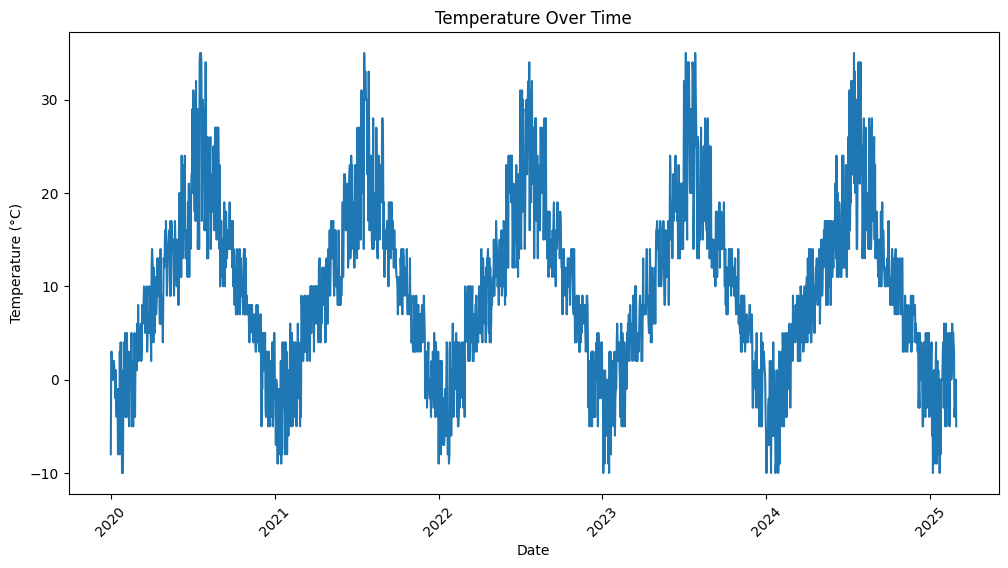

In [13]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='temperature', data=dummy_df)
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.show()

# Start creating dummy data

## Create rain

In [14]:
# Initialize the rain column with zeros
dummy_df['rain'] = 0

# Iterate over each month in the date range
for month in scope_table_df['Month']:
    # Get the number of rain days for the current month
    rain_days = scope_table_df.loc[scope_table_df['Month'] == month, 'Rain Days'].values[0]
    
    # Get all the dates for the current month
    month_dates = dummy_df[dummy_df['date'].dt.strftime('%B') == month]
    
    # Randomly select dates for rain
    rain_dates = np.random.choice(month_dates.index, size=rain_days, replace=False)
    
    # Set the rain column to 1 for the selected dates
    dummy_df.loc[rain_dates, 'rain'] = 1

# Display the updated DataFrame
dummy_df.head()

,date,temperature,month,seasons,rain
0,2020-01-01,-8,Jan,Winter,1
1,2020-01-02,3,Jan,Winter,0
2,2020-01-03,3,Jan,Winter,0
3,2020-01-04,2,Jan,Winter,0
4,2020-01-05,0,Jan,Winter,0


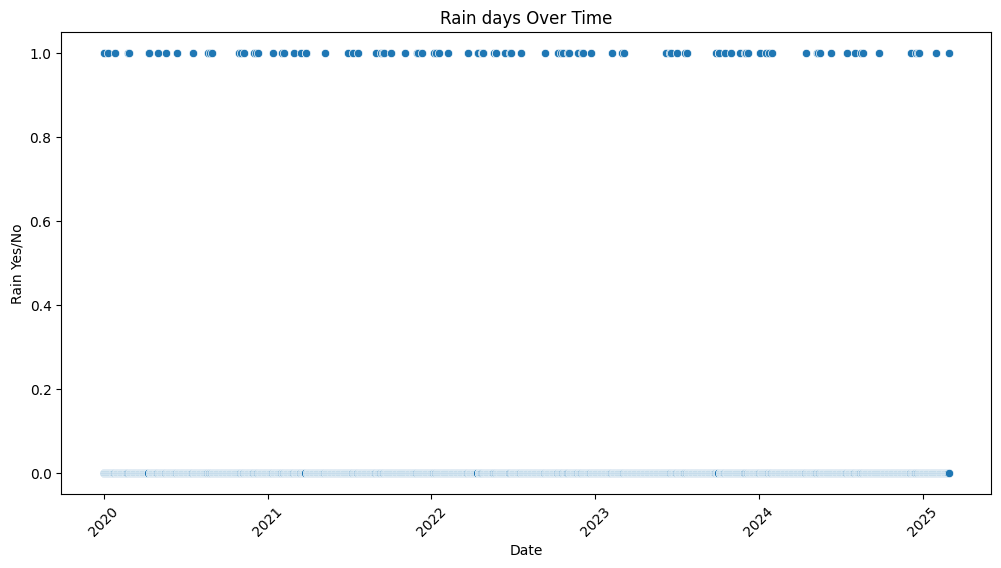

In [15]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='rain', data=dummy_df)
plt.title('Rain days Over Time')
plt.xlabel('Date')
plt.ylabel('Rain Yes/No')
plt.xticks(rotation=45)
plt.show()

## Create sunlight

In [16]:
# Create the sunlight column based on the rain column
dummy_df['sunlight'] = dummy_df['rain'].apply(lambda x: 0 if x == 1 else 1)

# Display the updated DataFrame
dummy_df.describe()

,date,temperature,rain,sunlight
count,1886,1886.000000,1886.000000,1886.000000
mean,2022-07-31 12:00:00,9.676034,0.055673,0.944327
min,2020-01-01 00:00:00,-10.000000,0.000000,0.000000
25%,2021-04-16 06:00:00,3.000000,0.000000,1.000000
50%,2022-07-31 12:00:00,9.000000,0.000000,1.000000
75%,2023-11-14 18:00:00,15.000000,0.000000,1.000000
max,2025-02-28 00:00:00,35.000000,1.000000,1.000000
std,NaN,9.031541,0.229351,0.229351


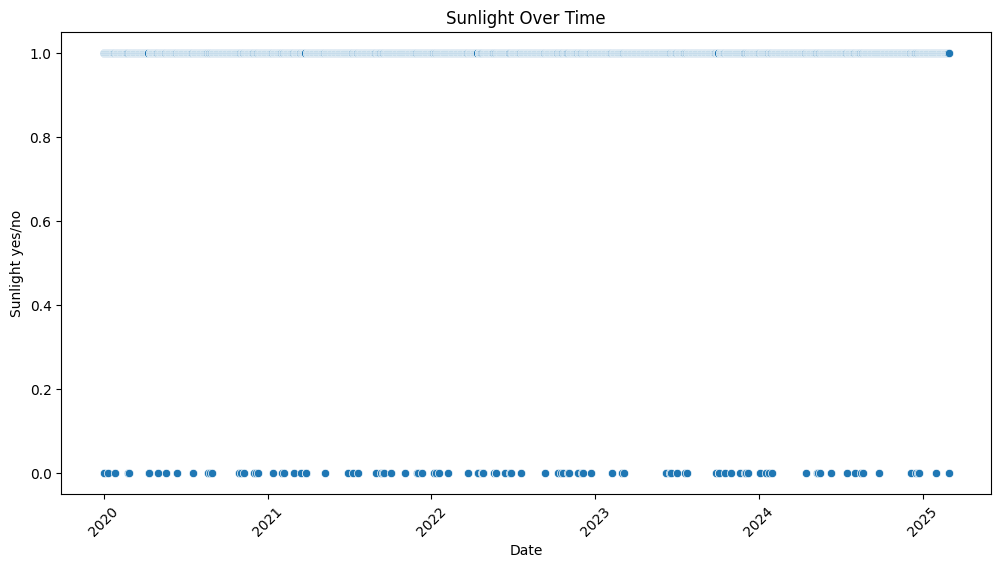

In [17]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='sunlight', data=dummy_df)
plt.title('Sunlight Over Time')
plt.xlabel('Date')
plt.ylabel('Sunlight yes/no')
plt.xticks(rotation=45)
plt.show()

## create wind

In [18]:
# Create the wind column based on the rain & temperature
dummy_df['wind'] = dummy_df.apply(lambda row: np.random.randint(15, 30) 
                                  if row['rain'] == 1 else np.random.randint(0, 6), axis=1)

dummy_df['wind'] = dummy_df.apply(lambda row: row['wind'] + np.random.randint(10, 30) 
                                  if row['temperature'] <= 10 else row['wind'] + np.random.randint(0, 6), axis=1)

dummy_df.describe()

,date,temperature,rain,sunlight,wind
count,1886,1886.000000,1886.000000,1886.000000,1886.000000
mean,2022-07-31 12:00:00,9.676034,0.055673,0.944327,15.488865
min,2020-01-01 00:00:00,-10.000000,0.000000,0.000000,0.000000
25%,2021-04-16 06:00:00,3.000000,0.000000,1.000000,5.000000
50%,2022-07-31 12:00:00,9.000000,0.000000,1.000000,15.000000
75%,2023-11-14 18:00:00,15.000000,0.000000,1.000000,24.000000
max,2025-02-28 00:00:00,35.000000,1.000000,1.000000,57.000000
std,NaN,9.031541,0.229351,0.229351,10.916594


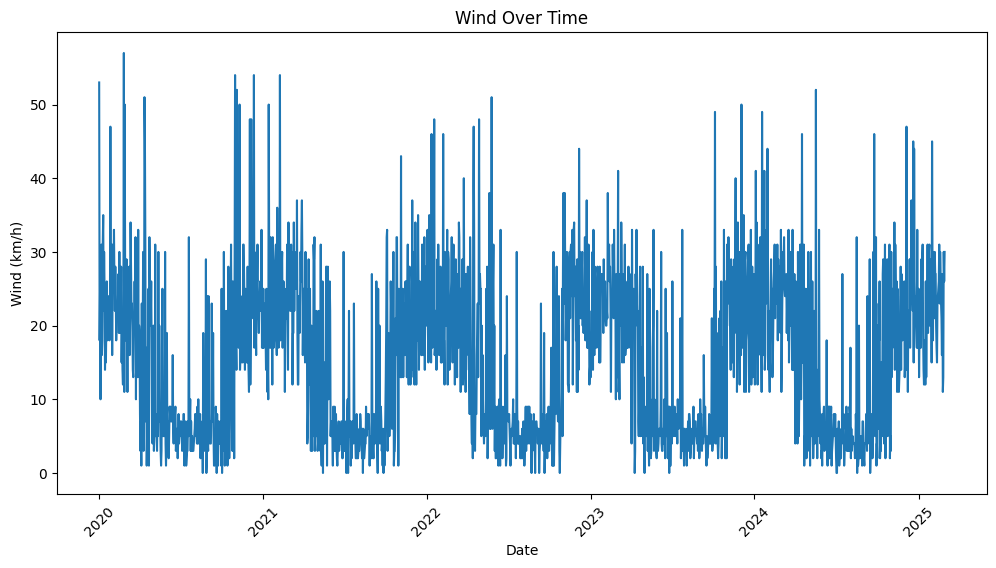

In [19]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='wind', data=dummy_df)
plt.title('Wind Over Time')
plt.xlabel('Date')
plt.ylabel('Wind (km/h)')
plt.xticks(rotation=45)
plt.show()

## Create mood

In [20]:
# Create the mood column and populate it with 0
dummy_df['mood'] = 0

# Modify mood based on rain and temperature conditions
dummy_df['mood'] = dummy_df.apply(lambda row: row['mood'] - np.random.randint(10, 31)
                                  if row['rain'] == 1 and row['temperature'] < 15 else
                                  row['mood'] - np.random.randint(0, 11)
                                  if row['rain'] == 0 and row['temperature'] < 15 else
                                  row['mood'] + np.random.randint(0, 11)
                                  if row['rain'] == 1 and row['temperature'] >= 15 else
                                  row['mood'] + np.random.randint(10, 31), axis=1)

# Modify mood based on wind conditions
dummy_df['mood'] = dummy_df.apply(lambda row: row['mood'] + np.random.randint(10, 31)
                                  if row['wind'] < 20 else
                                  row['mood'] - np.random.randint(10, 31), axis=1)

# Display the updated DataFrame
dummy_df.head()

,date,temperature,month,seasons,rain,sunlight,wind,mood
0,2020-01-01,-8,Jan,Winter,1,0,53,-50
1,2020-01-02,3,Jan,Winter,0,1,18,20
2,2020-01-03,3,Jan,Winter,0,1,25,-21
3,2020-01-04,2,Jan,Winter,0,1,10,6
4,2020-01-05,0,Jan,Winter,0,1,27,-25


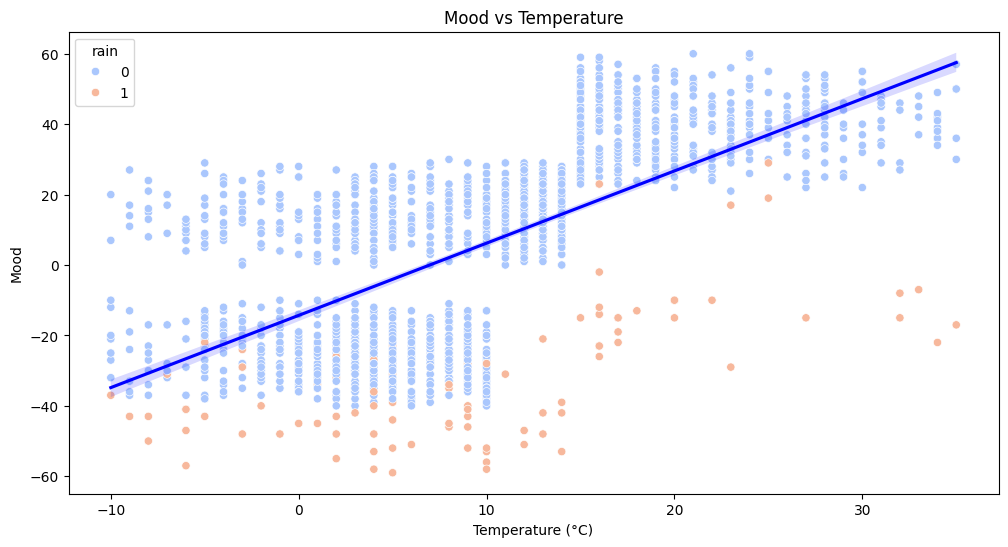

In [21]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='temperature', y='mood', hue='rain', data=dummy_df, palette='coolwarm')
sns.regplot(x='temperature', y='mood', data=dummy_df, scatter=False, color='blue')
plt.title('Mood vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Mood')
plt.show()

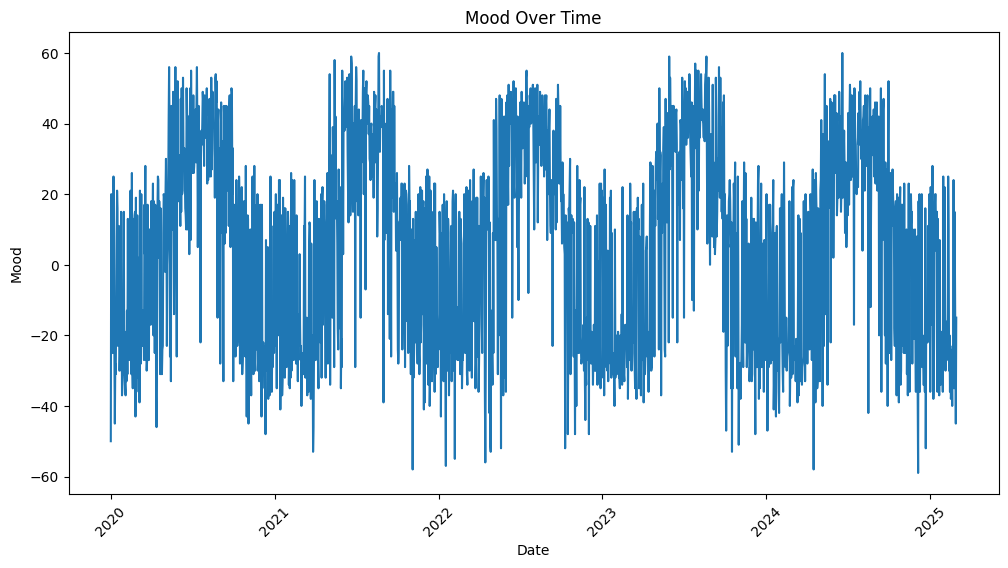

In [22]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='mood', data=dummy_df)
plt.title('Mood Over Time')
plt.xlabel('Date')
plt.ylabel('Mood')
plt.xticks(rotation=45)
plt.show()

## Create Walk

In [23]:
# Create the sunlight column based on the rain column
dummy_df['walk'] = 0

for index, row in dummy_df.iterrows():
    if row['mood'] <= -40:
        dummy_df.at[index, 'walk'] = 0
    elif row['mood'] > -40 and row['mood'] <= 0:
        dummy_df.at[index, 'walk'] = np.random.randint(0, 2)
    elif row['mood'] > 0:
        dummy_df.at[index, 'walk'] = 1

dummy_df.describe()

,date,temperature,rain,sunlight,wind,mood,walk
count,1886,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,2022-07-31 12:00:00,9.676034,0.055673,0.944327,15.488865,5.541357,0.801166
min,2020-01-01 00:00:00,-10.000000,0.000000,0.000000,0.000000,-59.000000,0.000000
25%,2021-04-16 06:00:00,3.000000,0.000000,1.000000,5.000000,-23.000000,1.000000
50%,2022-07-31 12:00:00,9.000000,0.000000,1.000000,15.000000,11.000000,1.000000
75%,2023-11-14 18:00:00,15.000000,0.000000,1.000000,24.000000,27.000000,1.000000
max,2025-02-28 00:00:00,35.000000,1.000000,1.000000,57.000000,60.000000,1.000000
std,NaN,9.031541,0.229351,0.229351,10.916594,28.348946,0.399228


# Make data categorical

## temperature

In [24]:
# Define a function to categorize temperature
def categorize_temperature(temp):
    if temp <= 0:
        return 'very cold'
    elif 0 < temp <= 10:
        return 'cold'
    elif 10 < temp <= 20:
        return 'warm'
    else:
        return 'hot'

# Apply the function to create the 'temperature_category' column
dummy_df['temperature_category'] = dummy_df['temperature'].apply(categorize_temperature)

# Display the updated DataFrame
dummy_df.head()

,date,temperature,month,seasons,rain,sunlight,wind,mood,walk,temperature_category
0,2020-01-01,-8,Jan,Winter,1,0,53,-50,0,very cold
1,2020-01-02,3,Jan,Winter,0,1,18,20,1,cold
2,2020-01-03,3,Jan,Winter,0,1,25,-21,0,cold
3,2020-01-04,2,Jan,Winter,0,1,10,6,1,cold
4,2020-01-05,0,Jan,Winter,0,1,27,-25,0,very cold


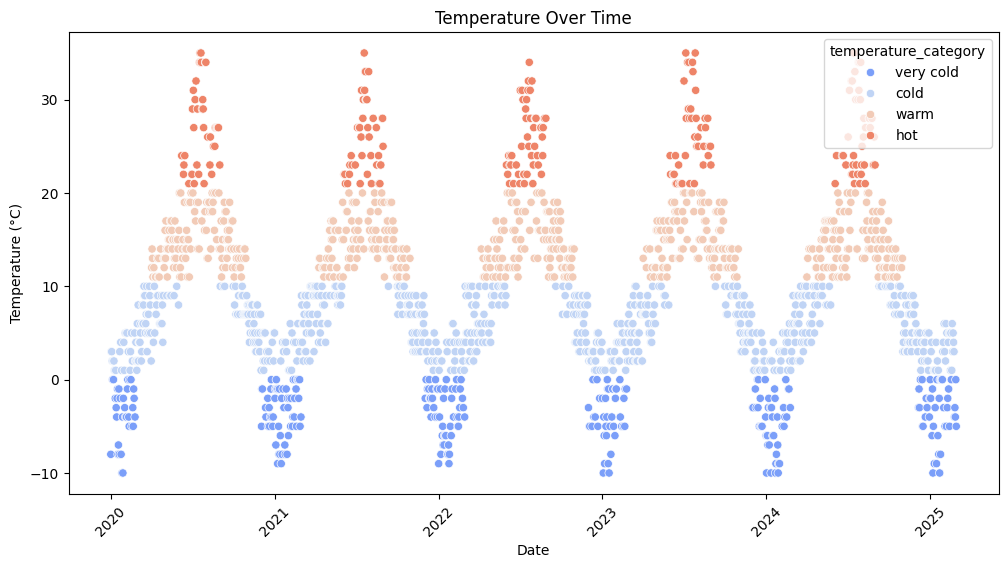

In [25]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='temperature', hue='temperature_category', data=dummy_df, palette='coolwarm')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.show()

## wind

In [26]:
# Define a function to categorize temperature
def categorize_wind(wind):
    if wind <= 1:
        return '0 calm'
    elif 1 < wind <= 5:
        return '1 light air'
    elif 5 < wind <= 11:
        return '2 light breeze'
    elif 11 < wind <= 20:
        return '3 gentle breeze'
    elif 20 < wind <= 28:
        return '4 moderate breeze'
    elif 28 < wind <= 38:
        return '5 fresh breeze'
    elif wind > 38:
        return '6 strong breeze'
    else:
        return 'debug'

# Apply the function to create the 'temperature_category' column
dummy_df['wind_category'] = dummy_df['wind'].apply(categorize_wind)

dummy_df.head()

,date,temperature,month,seasons,rain,sunlight,wind,mood,walk,temperature_category,wind_category
0,2020-01-01,-8,Jan,Winter,1,0,53,-50,0,very cold,6 strong breeze
1,2020-01-02,3,Jan,Winter,0,1,18,20,1,cold,3 gentle breeze
2,2020-01-03,3,Jan,Winter,0,1,25,-21,0,cold,4 moderate breeze
3,2020-01-04,2,Jan,Winter,0,1,10,6,1,cold,2 light breeze
4,2020-01-05,0,Jan,Winter,0,1,27,-25,0,very cold,4 moderate breeze


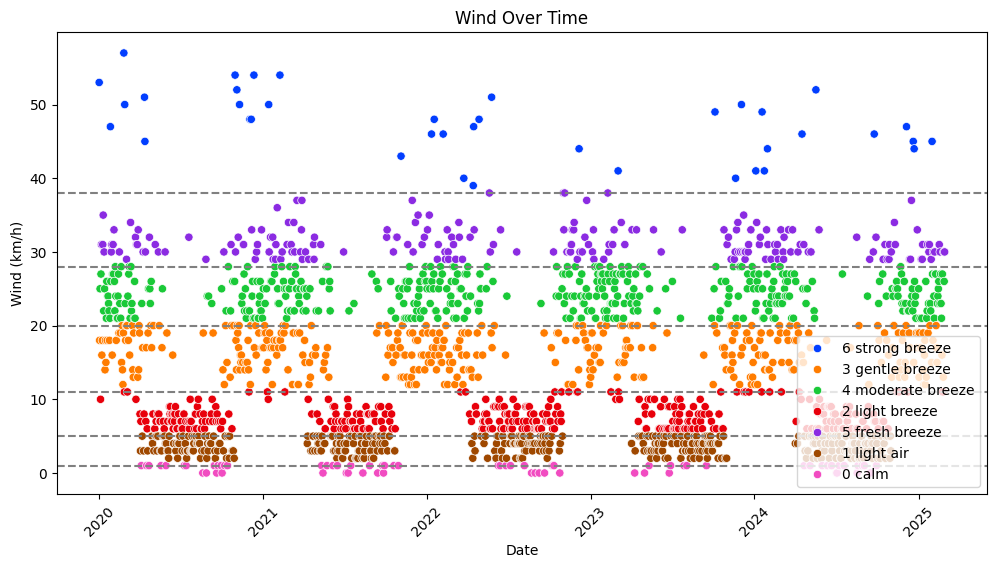

In [27]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='wind', hue='wind_category', data=dummy_df, palette='bright')

# Add horizontal lines for wind categories
plt.axhline(y=1, color='gray', linestyle='--', label='_nolegend_')
plt.axhline(y=5, color='gray', linestyle='--', label='_nolegend_')
plt.axhline(y=11, color='gray', linestyle='--', label='_nolegend_')
plt.axhline(y=20, color='gray', linestyle='--', label='_nolegend_')
plt.axhline(y=28, color='gray', linestyle='--', label='_nolegend_')
plt.axhline(y=38, color='gray', linestyle='--', label='_nolegend_')

plt.title('Wind Over Time')
plt.xlabel('Date')
plt.ylabel('Wind (km/h)')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

## mood

In [28]:
# Define a function to categorize temperature
def categorize_mood(mood):
    if mood <= -25:
        return '0 very bad'
    elif -25 < mood <= 0:
        return '1 bad'
    elif 0 < mood <= 10:
        return '2 okish'
    elif 10 < mood <= 30:
        return '3 good'
    elif mood > 30:
        return '4 very good'
    else:
        return 'debug'

# Apply the function to create the 'temperature_category' column
dummy_df['mood_category'] = dummy_df['mood'].apply(categorize_mood)

# Display the updated DataFrame
dummy_df.head()

,date,temperature,month,seasons,rain,sunlight,wind,mood,walk,temperature_category,wind_category,mood_category
0,2020-01-01,-8,Jan,Winter,1,0,53,-50,0,very cold,6 strong breeze,0 very bad
1,2020-01-02,3,Jan,Winter,0,1,18,20,1,cold,3 gentle breeze,3 good
2,2020-01-03,3,Jan,Winter,0,1,25,-21,0,cold,4 moderate breeze,1 bad
3,2020-01-04,2,Jan,Winter,0,1,10,6,1,cold,2 light breeze,2 okish
4,2020-01-05,0,Jan,Winter,0,1,27,-25,0,very cold,4 moderate breeze,0 very bad


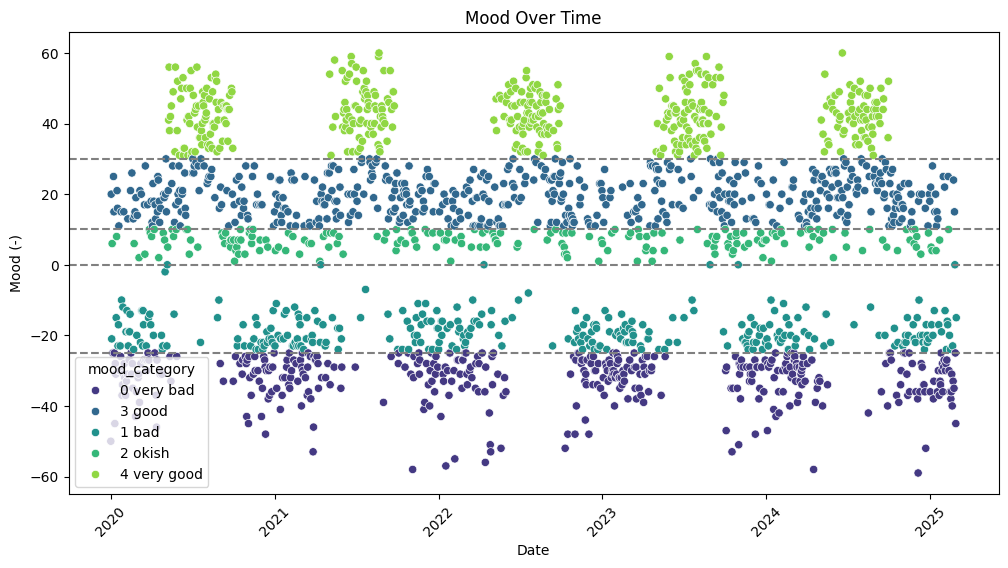

In [29]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='mood', hue='mood_category', data=dummy_df, palette='viridis')

# Add horizontal lines for mood categories
plt.axhline(y=-25, color='gray', linestyle='--', label='_nolegend_')
plt.axhline(y=0, color='gray', linestyle='--', label='_nolegend_')
plt.axhline(y=10, color='gray', linestyle='--', label='_nolegend_')
plt.axhline(y=30, color='gray', linestyle='--', label='_nolegend_')

plt.title('Mood Over Time')
plt.xlabel('Date')
plt.ylabel('Mood (-)')
plt.xticks(rotation=45)
plt.show()

# Export Data

## EDA

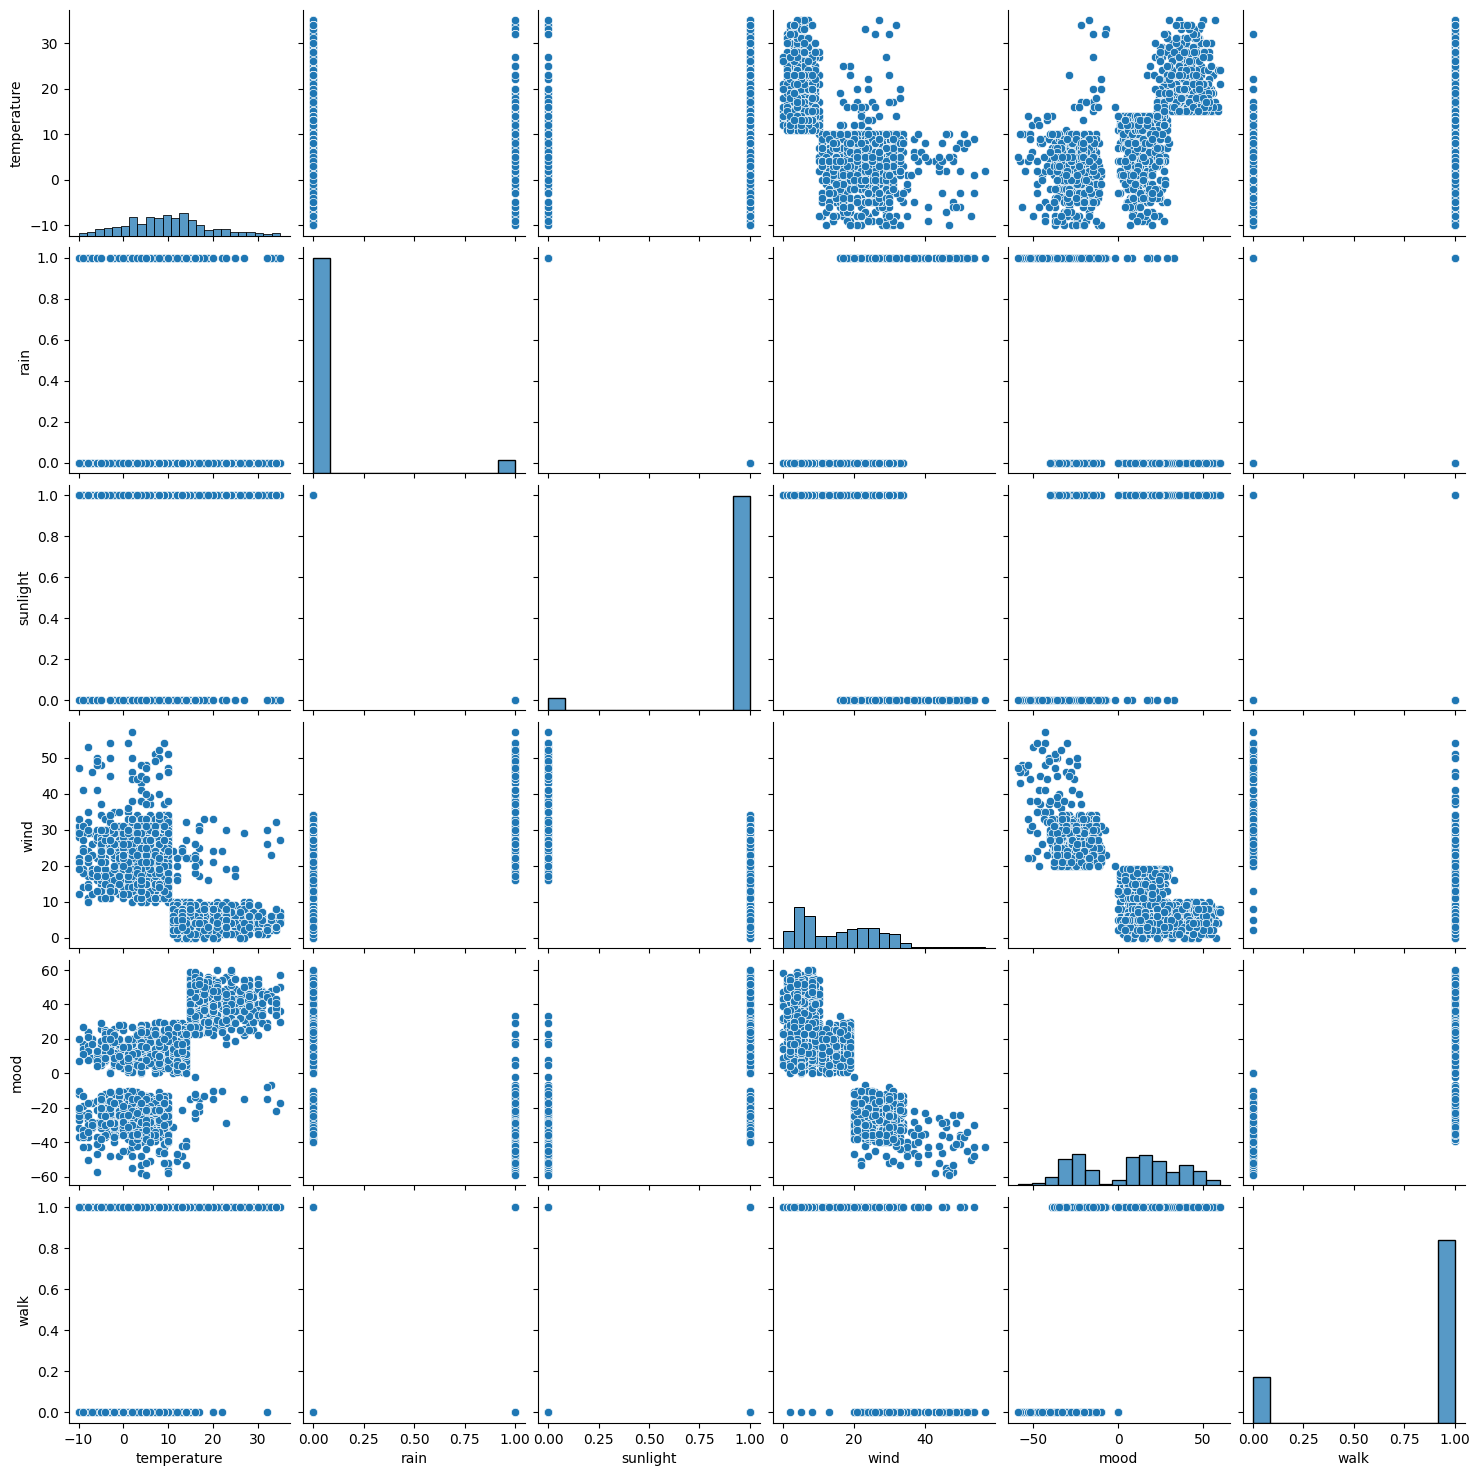

In [30]:
# Create a pair plot using seaborn
sns.pairplot(dummy_df)
plt.savefig('./images/pairs_plot_plain.png')
plt.show()

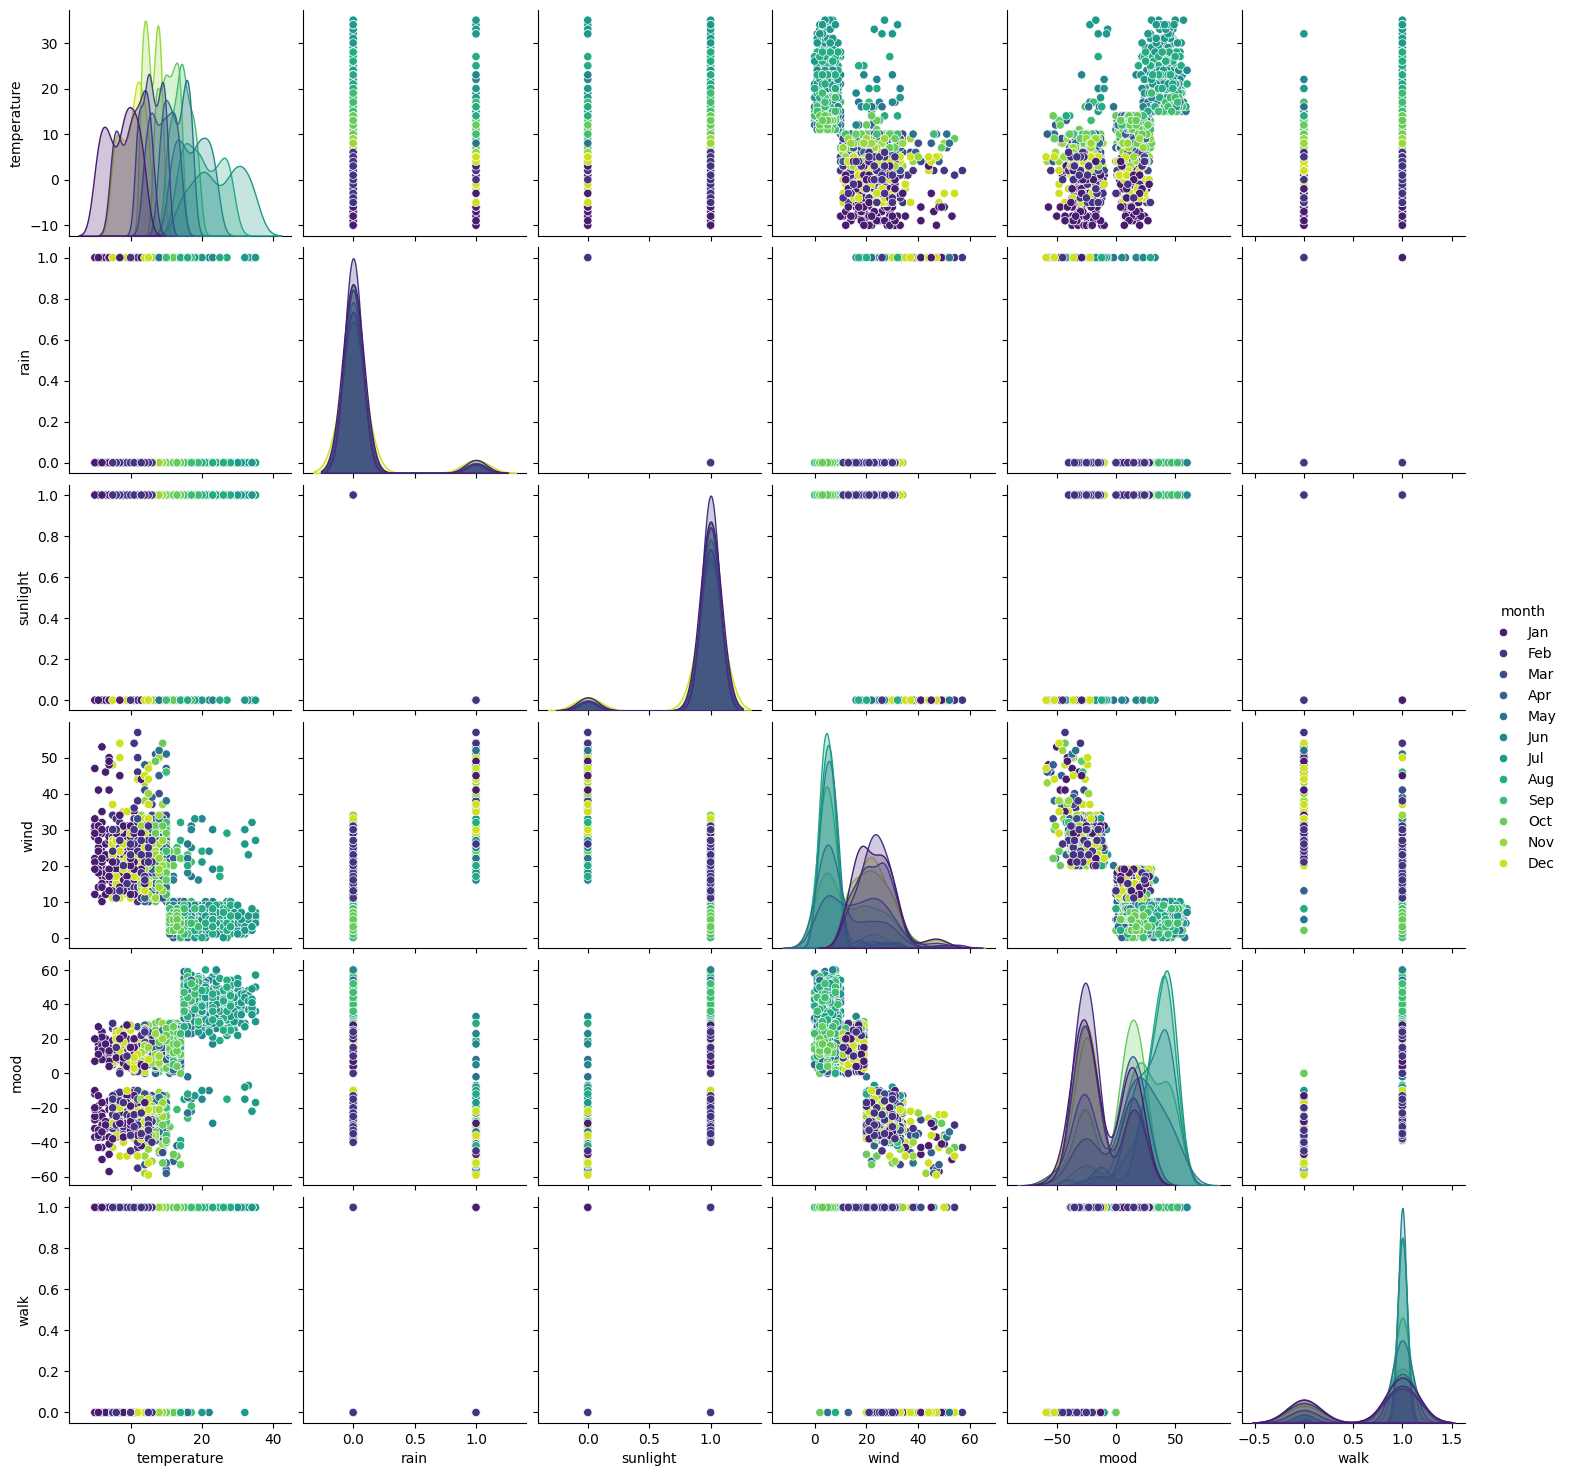

In [31]:
# Create a pair plot using seaborn
sns.pairplot(dummy_df, hue='month', palette='viridis')
plt.savefig('./images/pairs_plot_months.png')
plt.show()

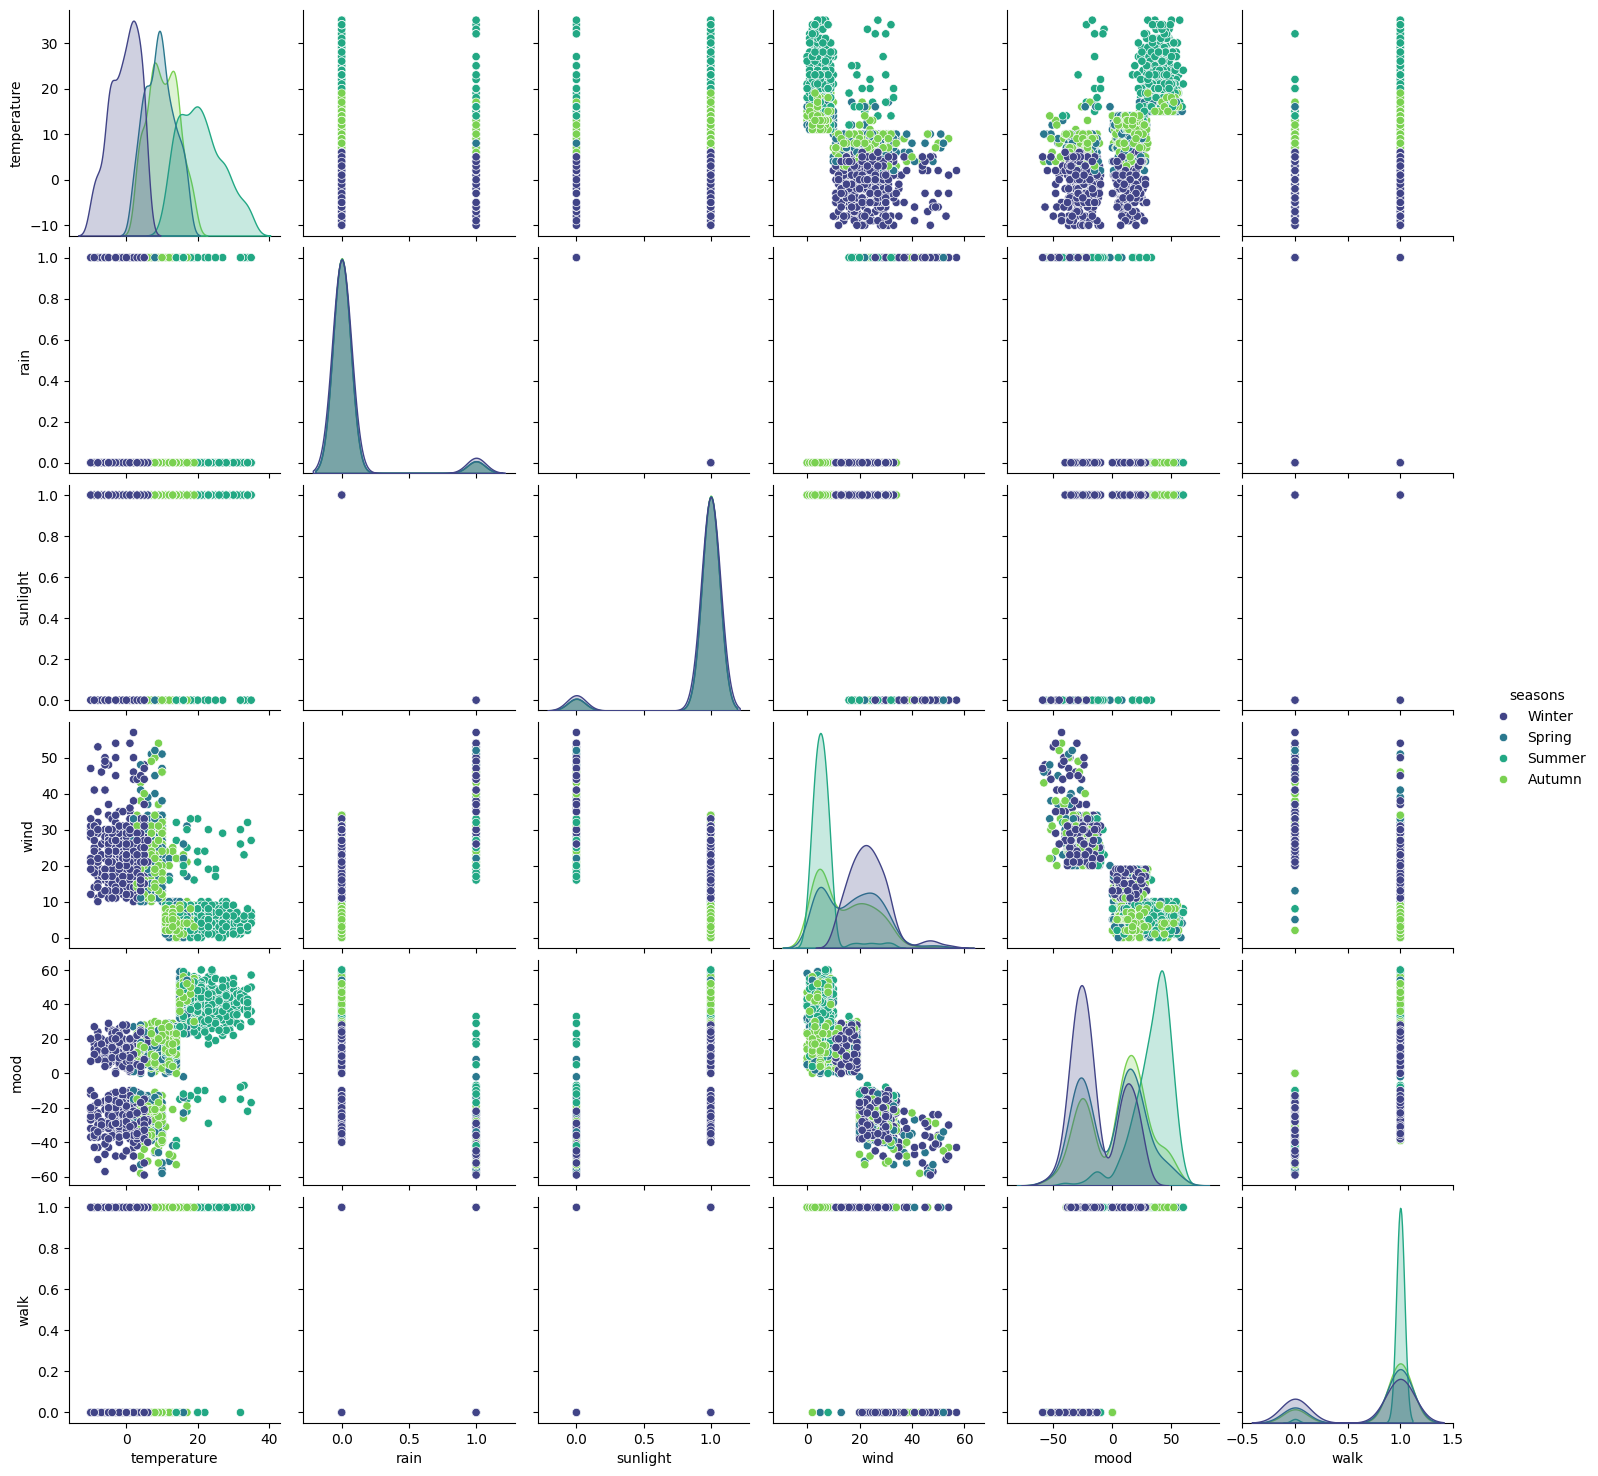

In [32]:
# Create a pair plot using seaborn
sns.pairplot(dummy_df, hue='seasons', palette='viridis')
plt.savefig('./images/pairs_plot_seasons.png')
plt.show()

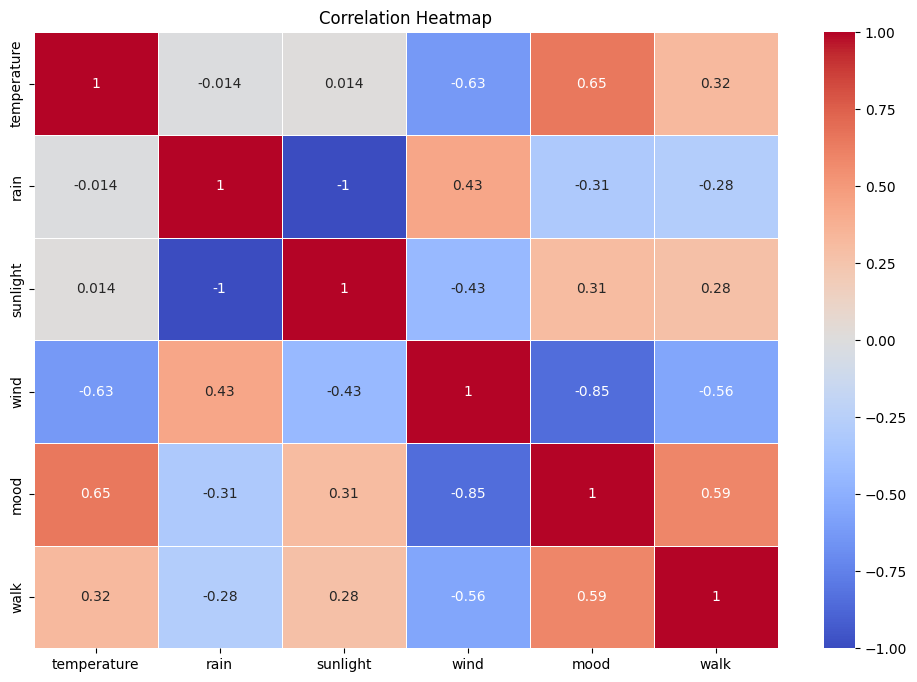

In [33]:
# Select only numeric columns for correlation matrix calculation
numeric_df = dummy_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.savefig('./images/corrs_plot.png')
plt.show()

export as csv

In [34]:
# Export the dummy_df DataFrame to a CSV file
dummy_df.to_csv('./data/dummy_data.csv', index=False)

In [35]:
# Save the dummy_df DataFrame to an Excel file
dummy_df.to_excel('./data/dummy_data.xlsx', index=False)

# Add New data

In [36]:
# Filter the data for March 2024
march_2024_data = dummy_df[dummy_df['date'].dt.strftime('%Y-%m') == '2024-03'].copy()

# Update the date to March 2025
march_2024_data['date'] = march_2024_data['date'] + pd.DateOffset(years=1)

# make a list of DataFrames to join
df_list = [dummy_df, march_2024_data]

# Append the new data to dummy_df
dummy_df_updated = pd.concat(df_list)

# Display the updated DataFrame
dummy_df_updated.tail()

,date,temperature,month,seasons,rain,sunlight,wind,mood,walk,temperature_category,wind_category,mood_category
1547,2025-03-27,10,Mar,Spring,0,1,14,11,1,cold,3 gentle breeze,3 good
1548,2025-03-28,5,Mar,Spring,0,1,21,-33,1,cold,4 moderate breeze,0 very bad
1549,2025-03-29,9,Mar,Spring,0,1,14,20,1,cold,3 gentle breeze,3 good
1550,2025-03-30,4,Mar,Spring,0,1,27,-12,1,cold,4 moderate breeze,1 bad
1551,2025-03-31,10,Mar,Spring,0,1,18,12,1,cold,3 gentle breeze,3 good


In [37]:
march_2024_data.head()

,date,temperature,month,seasons,rain,sunlight,wind,mood,walk,temperature_category,wind_category,mood_category
1521,2025-03-01,9,Mar,Spring,0,1,11,22,1,cold,2 light breeze,3 good
1522,2025-03-02,5,Mar,Spring,0,1,15,24,1,cold,3 gentle breeze,3 good
1523,2025-03-03,6,Mar,Spring,0,1,23,-25,1,cold,4 moderate breeze,0 very bad
1524,2025-03-04,5,Mar,Spring,0,1,27,-27,0,cold,4 moderate breeze,0 very bad
1525,2025-03-05,7,Mar,Spring,0,1,30,-26,0,cold,5 fresh breeze,0 very bad


export the new data

In [38]:
# export the joined data to a csv
dummy_df_updated.to_csv('./data/to_predict_long.csv', index=False)

# Export the march_2024_data DataFrame to a CSV file
march_2024_data.to_csv('./data/to_predict_short.csv', index=False)